In [1]:
# reload magic
import importlib
import gpudrive
importlib.reload(gpudrive)
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader

from gpudrive.visualize.utils import img_from_fig

import torch
from PIL import Image

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'

plt.set_loglevel("WARNING")
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_agent_guidance_info(guidance_obs, center_agent_idx):
 
    agent_guidance = guidance_obs[center_agent_idx, :, :]
    
    time_steps = np.arange(agent_guidance.shape[0])
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
    
    # Find where the one-hot encoding is 1 (next timestep indicator)
    next_timestep_idx = np.where(agent_guidance[:, 3] == 1)[0][0]
    
    axes[0].plot(time_steps, agent_guidance[:, 0], label='x-position')
    axes[0].plot(time_steps, agent_guidance[:, 1], label='y-position')
    
    axes[0].scatter(time_steps[next_timestep_idx], agent_guidance[next_timestep_idx, 0], color='purple', marker='^', s=100, zorder=5, label='_nolegend_')
    axes[0].scatter(time_steps[next_timestep_idx], agent_guidance[next_timestep_idx, 1], color='purple', marker='^', s=100, zorder=5, label='_nolegend_')
    
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Suggested position (x,y)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(time_steps, agent_guidance[:, 2])
    

    axes[1].scatter(time_steps[next_timestep_idx], agent_guidance[next_timestep_idx, 2], color='purple', marker='^', s=100, zorder=5)
    
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Suggested speed')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(time_steps, agent_guidance[:, 4])
    axes[2].scatter(time_steps[next_timestep_idx], agent_guidance[next_timestep_idx, 4], color='purple', marker='^', s=100, zorder=5)
    
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Suggested heading (rad)')
    axes[2].set_title('Heading')
    axes[2].grid(True, alpha=0.3)
    
    fig.suptitle(f"Agent's {center_agent_idx} normalized guidance information")
    
    # Add a unified legend for the purple triangle
    triangle_patch = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='purple')
    fig.legend([triangle_patch], ['Next timestep indicator'], loc='lower center', bbox_to_anchor=(0.53, -0.15), facecolor='white')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)
    
    return fig

### Make environment

In [3]:
env_config = EnvConfig(
    dynamics_model="classic",
    reward_type="guided_autonomy",
    guidance=True,
    add_reference_heading=True,
    add_reference_speed=True,
    add_reference_pos_xy=True,
    init_mode="womd_tracks_to_predict"
)
render_config = RenderConfig()

train_loader = SceneDataLoader(
    root="/home/emerge/gpudrive/data/processed/wosac/debug",
    batch_size=1,
    dataset_size=100,
    sample_with_replacement=False,
    shuffle=False,
    file_prefix="",
)

print(train_loader.dataset)

env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=64, 
    device="cpu",
)

['/home/emerge/gpudrive/data/processed/wosac/debug/1ce3b38fe5cd2597.json']


In [4]:
env_idx = 0
center_agent_idx = 12

control_mask = env.cont_agent_mask

print(f'Controllable agents: {torch.where(env.cont_agent_mask[env_idx, :])[0]}')
print(f'Controlling agent {center_agent_idx} in env {env_idx}.')

Controllable agents: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])
Controlling agent 12 in env 0.


### Step env

In [5]:
obs = env.reset(control_mask)

expert_actions, _, _, _ = env.get_expert_actions()

# for t in range(1):
#     env.step_dynamics(expert_actions[:, :, t, :])
#     obs = env.get_obs(control_mask)

### Show agent guidance information 


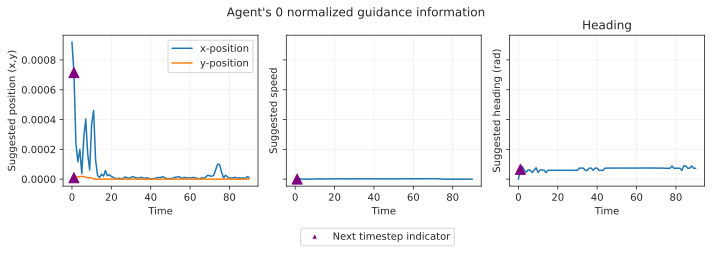

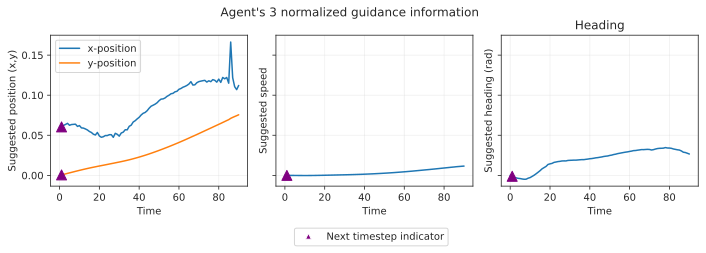

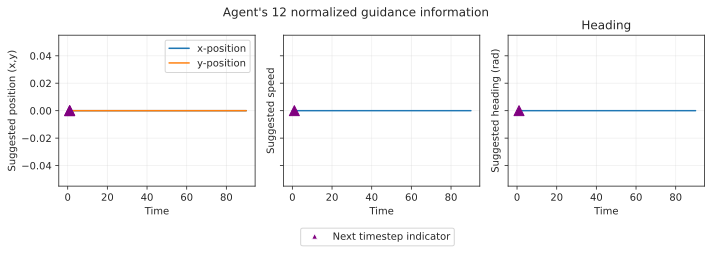

In [6]:
for center_agent_idx in [0, 3, 12]:
    plot_agent_guidance_info(env.guidance_obs, center_agent_idx)

### Show corresponding full agent views

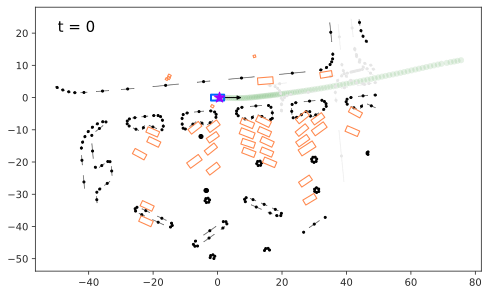

In [7]:
center_agent_idx=3

traj_masked = env.reference_path[center_agent_idx, :, :]

agent_obs_masked = env.vis.plot_agent_observation(
    env_idx=env_idx,
    agent_idx=center_agent_idx,
    figsize=(8, 8),
    trajectory=traj_masked,
)

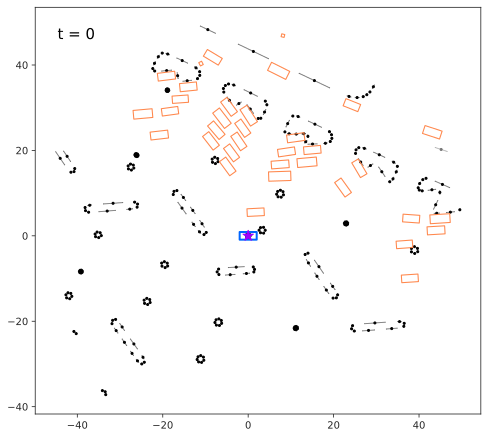

In [10]:
center_agent_idx=40

traj_masked = env.reference_path[center_agent_idx, :, :]

agent_obs_masked = env.vis.plot_agent_observation(
    env_idx=env_idx,
    agent_idx=center_agent_idx,
    figsize=(8, 8),
    trajectory=traj_masked,
)

### Simulator state centered at that agent

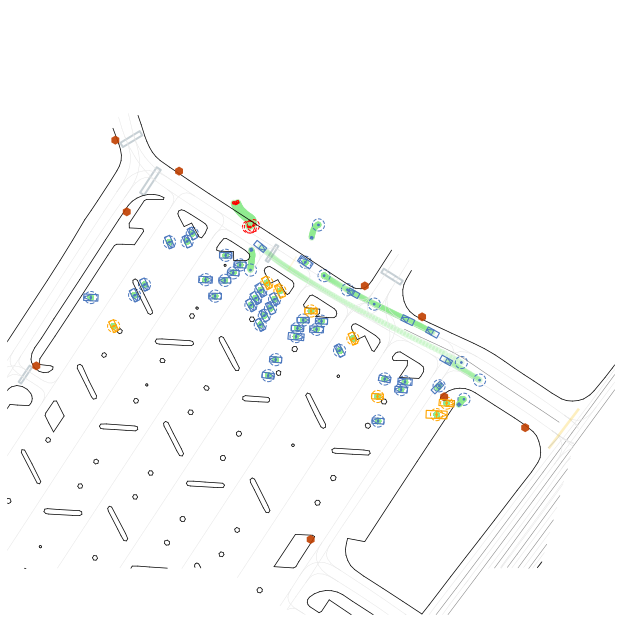

In [9]:
sim_states = env.vis.plot_simulator_state(
    env_indices=env_idx,
    zoom_radius=100,
    plot_guidance_pos_xy=True,
    center_agent_indices=[center_agent_idx],
)
#Image.fromarray(img_from_fig(sim_states[0]))
sim_states[0]

### Verify indexing

In [4]:
obs = env.reset(control_mask)

In [6]:
traj_masked = env.reference_path[2, :, :]

traj_masked.shape

torch.Size([91, 3])

valid: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True])


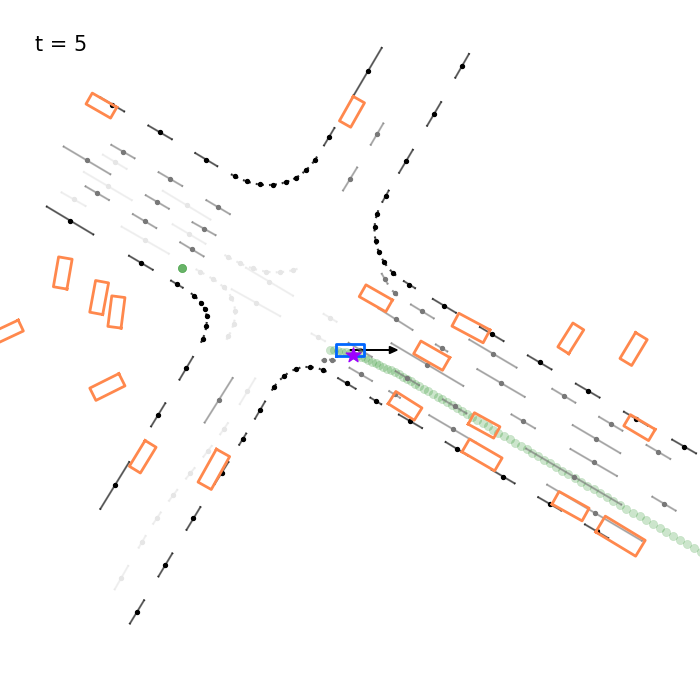

In [7]:
traj_masked = env.reference_path[2, :, :]

agent_obs_masked = env.vis.plot_agent_observation(
    env_idx=env_i,
    agent_idx=agent_j,
    figsize=(7, 7),
    trajectory=traj_masked,
)

Image.fromarray(img_from_fig(agent_obs_masked))

In [41]:
env.log_trajectory.valids.bool()[control_mask].shape

torch.Size([10, 91, 1])

In [42]:
#env.log_trajectory.pos_xy[env_i, agent_j]

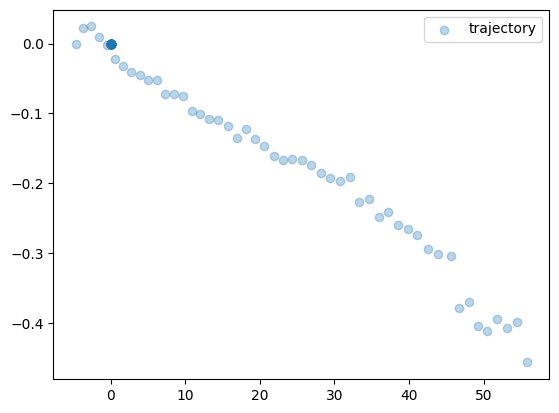

In [43]:
%matplotlib inline

#plt.scatter(traj[:, 0], traj[:, 1], label="trajectory", alpha=0.3)
plt.scatter(traj_masked[:, 0], traj_masked[:, 1], label="trajectory", alpha=0.3)
plt.legend()
plt.show()

In [83]:
traj_masked.shape

torch.Size([91, 2])

### Plot agent observation with other traj

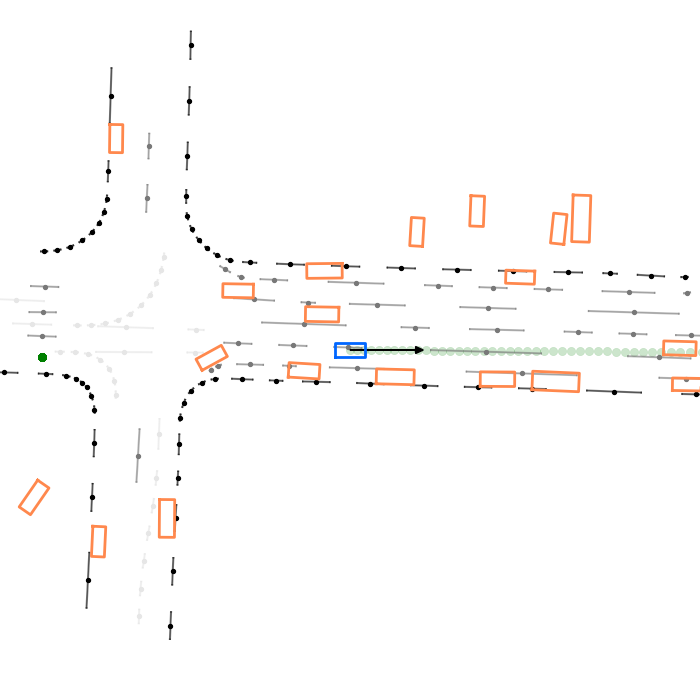

In [14]:
obs = env.reset()

traj = env.local_reference_xy[env_i, agent_j, :]

agent_obs = env.vis.plot_agent_observation(
    env_idx=env_i,
    agent_idx=agent_j,
    figsize=(7, 7),
    trajectory=traj,
)
Image.fromarray(img_from_fig(agent_obs))

In [15]:
traj.shape

torch.Size([91, 2])

In [71]:
traj_masked.shape

torch.Size([91, 2])

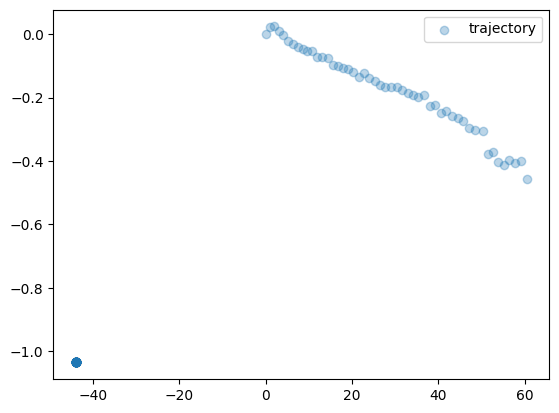

In [18]:
%matplotlib inline

plt.scatter(traj[:, 0], traj[:, 1], label="trajectory", alpha=0.3)
#plt.scatter(traj_masked[:, 0], traj_masked[:, 1], label="masked trajectory", alpha=0.3)
plt.legend()
plt.show()

In [5]:
from gpudrive.datatypes.trajectory import LogTrajectory, to_local_frame

global_ego_states = (
    env.sim.absolute_self_observation_tensor()
    .to_torch()
    .clone()
)

X_global = global_ego_states[:, :, :2]
theta_global = global_ego_states[:, :, 7]
Y_global = env.log_trajectory.pos_xy

print(f"shapes: {X_global.shape}, {theta_global.shape}, {Y_global.shape}")

shapes: torch.Size([1, 64, 2]), torch.Size([1, 64]), torch.Size([1, 64, 91, 2])


### Ground-truth

In [6]:
# 1) Translate
Y_bar = Y_global[env_i, agent_j, :] - X_global[env_i, agent_j, :]

print(Y_bar.shape)
print(Y_bar[:10])
print(" ")

# 2) Rotate
cos_yaw = torch.cos(theta_global[env_i, agent_j])
sin_yaw = torch.sin(theta_global[env_i, agent_j])
rotation_matrix = torch.tensor(
    [[cos_yaw, sin_yaw], [-sin_yaw, cos_yaw]]
)

print(f' R = {rotation_matrix.shape} =')
print(rotation_matrix)

# 3) Transform
Y_local = torch.matmul(Y_bar, rotation_matrix.T)

print(" ")
print(f' Y_local = {Y_local.shape} =')
print(
    Y_local[:5]
)

torch.Size([91, 2])
tensor([[ 0.0000,  0.0000],
        [-0.2891,  0.1440],
        [-0.6191,  0.2827],
        [-0.9414,  0.4409],
        [-1.3057,  0.6079],
        [-1.6631,  0.7720],
        [-2.0215,  0.9507],
        [-2.4121,  1.1333],
        [-2.8125,  1.3320],
        [-3.2266,  1.5381]])
 
 R = torch.Size([2, 2]) =
tensor([[-0.9079,  0.4191],
        [-0.4191, -0.9079]])
 
 Y_local = torch.Size([91, 2]) =
tensor([[ 0.0000,  0.0000],
        [ 0.3228, -0.0096],
        [ 0.6806,  0.0028],
        [ 1.0395, -0.0057],
        [ 1.4402, -0.0047]])


### Batched

In [7]:
# 1) Translate
Y_bar_batched = Y_global[env_i] - X_global[env_i].unsqueeze(1)

print(Y_bar.shape)
print(Y_bar[agent_j, :10])

# 2) Rotate
cos_yaw = torch.cos(theta_global[env_i])
sin_yaw = torch.sin(theta_global[env_i])
R_batched = torch.stack(
    [
        torch.stack([cos_yaw, sin_yaw], dim=1),
        torch.stack([-sin_yaw, cos_yaw], dim=1),
    ],
    dim=1,
) 

print(f' ')
print(f' R = {R_batched.shape} =')
print(R_batched[agent_j, :, :])

# 3) Transform
Y_local_batched = torch.bmm(
    Y_bar_batched, R_batched.transpose(1, 2)
)

print(" ")
print(f' Y_local = {Y_local_batched.shape} =')
print(
    Y_local_batched[agent_j, :10]
)

torch.Size([91, 2])
tensor([-1.3057,  0.6079])
 
 R = torch.Size([64, 2, 2]) =
tensor([[-0.9079,  0.4191],
        [-0.4191, -0.9079]])
 
 Y_local = torch.Size([64, 91, 2]) =
tensor([[ 0.0000e+00,  0.0000e+00],
        [ 3.2282e-01, -9.6245e-03],
        [ 6.8063e-01,  2.8185e-03],
        [ 1.0395e+00, -5.7459e-03],
        [ 1.4402e+00, -4.6898e-03],
        [ 1.8335e+00, -3.8388e-03],
        [ 2.2338e+00, -1.5878e-02],
        [ 2.6650e+00, -1.7957e-02],
        [ 3.1118e+00, -3.0572e-02],
        [ 3.5741e+00, -4.4107e-02]])


In [8]:
torch.equal(
    Y_local_batched[agent_j, :], Y_local[:]
)

True

In [9]:
agent_obs = env.vis.plot_agent_observation(
    env_idx=env_idx,
    agent_idx=highlight_agent,
    figsize=(10, 10),
    trajectory=Y_local,
)

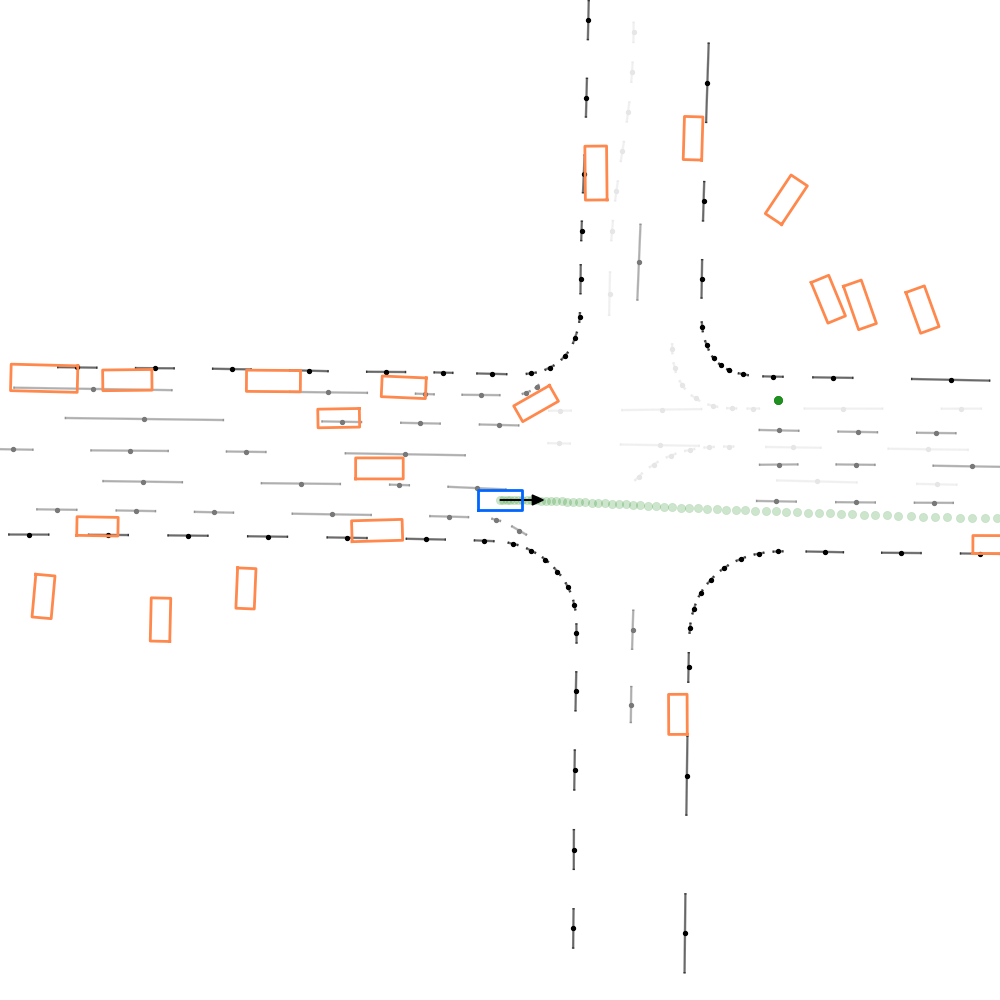

In [10]:
Image.fromarray(img_from_fig(agent_obs))

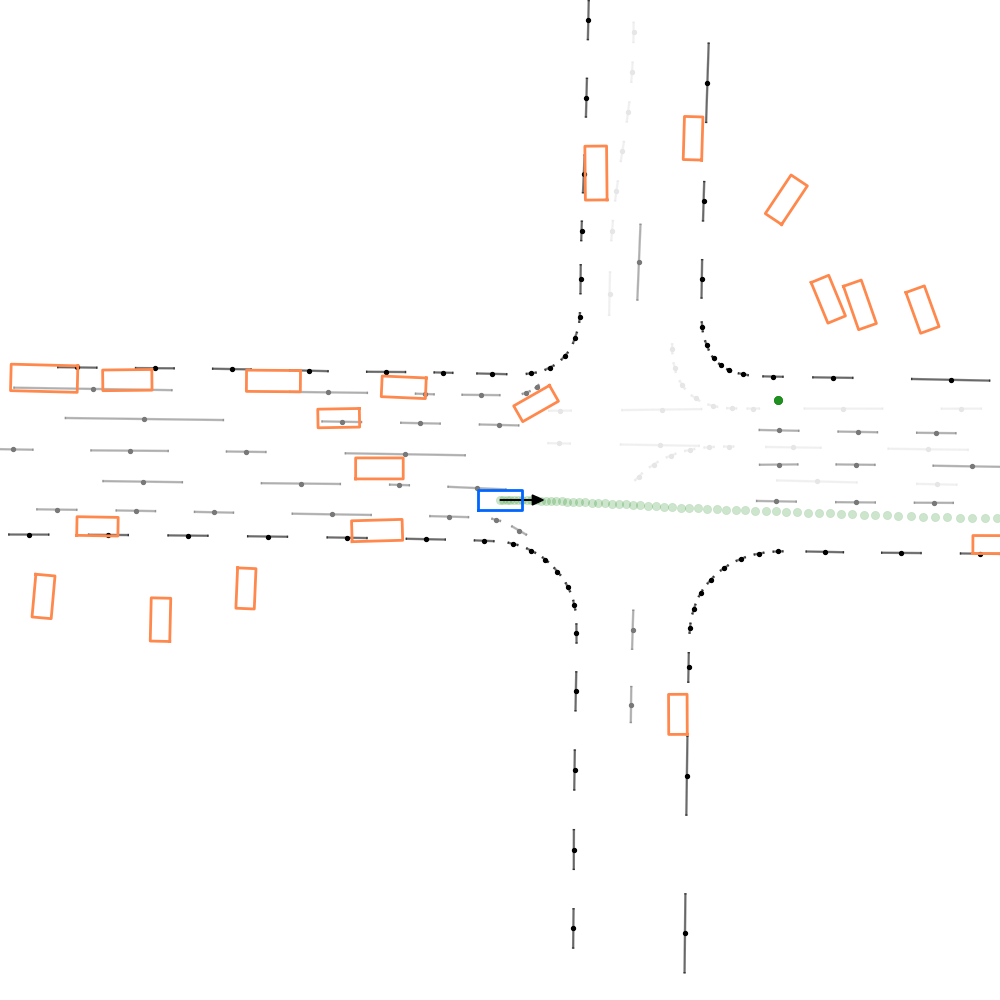

In [11]:
agent_obs = env.vis.plot_agent_observation(
    env_idx=env_idx,
    agent_idx=highlight_agent,
    figsize=(10, 10),
    trajectory=Y_local_batched[agent_j, :]
)

Image.fromarray(img_from_fig(agent_obs))